# Wind exposure plot

In [138]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
import json
from datetime import datetime
from zoneinfo import ZoneInfo

import geopandas as gpd
import ocha_stratus as stratus
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.ticker as mtick

import numpy as np

from src.datasources.meteofr import (
    parse_track_json,
    prepare_wind_contours,
    expand_quad_col,
    calculate_wind_buffers_gdf,
)
from src.monitoring.plotting import plot_bullseye_exposures, plot_wind_buffers
from src.utils.exposure import calculate_multi_adm_exposure
from src.utils.blob_utils import PROJECT_PREFIX

## Load data

### CODAB

In [140]:
adm1 = stratus.codab.load_codab_from_fieldmaps(iso3="mdg", admin_level=1)

KeyboardInterrupt: 

<Axes: >

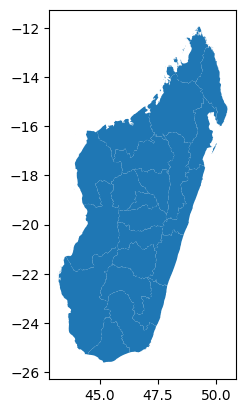

In [141]:
adm1.plot()

### Meteo France track forecast

In [ ]:
# from blob
blob_name = (
    "RSMC_LaReunion/CMRSTRACK_SWI$10_20252026_10-20252026_2026_02_07_12Z.json"
)
data = stratus.load_blob_data(blob_name, container_name="meteofr")

fcast_dict = json.loads(data)

In [148]:
# local file
local_path = "temp/CMRSTRACK_SWI$10_20252026_GEZANI_2026_02_09_12Z.json"

with open(local_path, "r", encoding="utf-8") as f:
    fcast_dict = json.load(f)

In [149]:
records, fc_details, uncertainty_cone = parse_track_json(fcast_dict)

In [150]:
speeds = [28, 34, 48, 64]

In [151]:
records = prepare_wind_contours(records)

for speed in speeds:
    col = f"wind_contour_{speed}kt"
    records = expand_quad_col(records, col)

In [152]:
records["lon"] = records.geometry.x
records["lat"] = records.geometry.y

### WP

In [11]:
blob_name = "worldpop/pop_count/global_pop_2026_CN_1km_R2025A_UA_v1.tif"
da_wp_global = stratus.open_blob_cog(blob_name, container_name="raster")

In [12]:
da_wp = da_wp_global.rio.clip(adm1.geometry).squeeze(drop=True).compute()

In [13]:
da_wp.attrs["_FillValue"] = None
da_wp = da_wp.where(da_wp > 0)

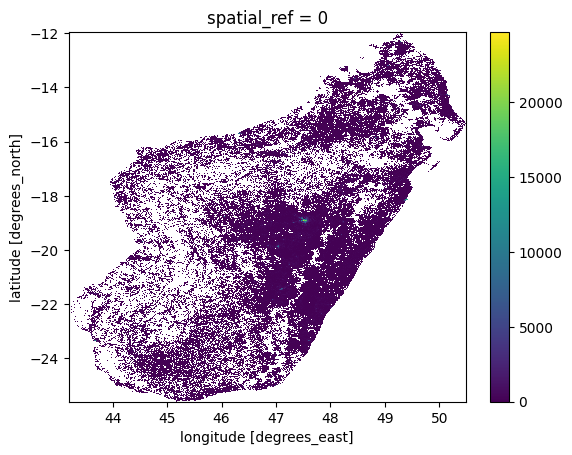

In [14]:
da_wp.plot()

In [15]:
da_wp.sum()

<xarray.DataArray ()> Size: 4B
array(32938792., dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     None

### Bubbles Template

In [16]:
blob_name = f"{PROJECT_PREFIX}/processed/plotting/adm1_template.parquet"
template_df = stratus.load_parquet_from_blob(blob_name)

## Calculate exposure

### Calculate wind buffers

In [153]:
gdf_buffers = calculate_wind_buffers_gdf(
    records,
    valid_time_col="time",
    quad_cols_format="wind_contour_{speed}kt_{quad}",
    lat_col="lat",
    lon_col="lon",
    speeds=speeds,
)

In [154]:
gdf_buffers

,speed,geometry
0,28,"MULTIPOLYGON (((4419521.657 -2937009.042, 4421..."
1,34,"POLYGON ((4253105.688 -2932613.515, 4254088.61..."
2,48,"MULTIPOLYGON (((4151840.973 -2978382.314, 4152..."
3,64,"MULTIPOLYGON (((4133735.874 -2977971.627, 4134..."


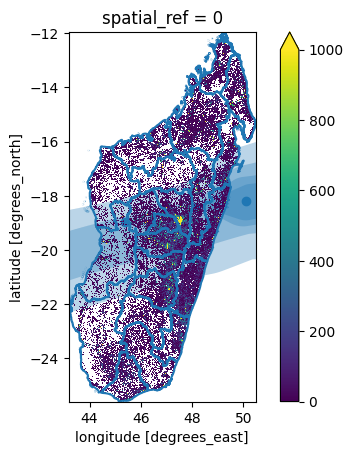

In [155]:
fig, ax = plt.subplots()
gdf_buffers.to_crs(4326).plot(ax=ax, alpha=0.3)
records.plot(ax=ax)
adm1.boundary.plot(ax=ax)
da_wp.plot(ax=ax, vmax=1000)

### Overlay and calculate exposure

In [156]:
df_exp = calculate_multi_adm_exposure(
    gdf_buffers, da_wp, adm1, adm_index="adm1_src", disable_tqdm=False
)

  0%|          | 0/22 [00:00<?, ?it/s]

In [157]:
df_exp

,speed,pop_exposed,adm1_src
0,28,4621438,MG11
1,34,4418074,MG11
2,48,0,MG11
3,64,0,MG11
4,28,2706843,MG12
...,...,...,...
83,64,0,MG71
84,28,0,MG72
85,34,0,MG72
86,48,0,MG72


In [158]:
df_exp["speed_kmh"] = (df_exp["speed"] * 1.852).astype(int)

In [159]:
df_exp["speed_kmh"].unique()

array([ 51,  62,  88, 118])

In [160]:
df_exp

,speed,pop_exposed,adm1_src,speed_kmh
0,28,4621438,MG11,51
1,34,4418074,MG11,62
2,48,0,MG11,88
3,64,0,MG11,118
4,28,2706843,MG12,51
...,...,...,...,...
83,64,0,MG71,118
84,28,0,MG72,51
85,34,0,MG72,62
86,48,0,MG72,88


## Plot

In [161]:
colors = {51: "gold", 62: "darkorange", 88: "crimson", 118: "indigo"}

In [162]:
colors.keys()

dict_keys([51, 62, 88, 118])

In [163]:
fc_details

{'cyclone_name': 'GEZANI',
 'season': 20252026,
 'reference_time': '2026-02-09T12:00:00Z',
 'basin': 'SWI'}

In [164]:
def dt_to_EAT(s):
    dt_utc = datetime.fromisoformat(s.replace("Z", "+00:00"))
    return dt_utc.astimezone(ZoneInfo("Africa/Nairobi"))

In [165]:
dt_eat = dt_to_EAT(fc_details["reference_time"])

In [166]:
issued_time_str = dt_eat.strftime("%Y-%m-%d %H:%M")

In [167]:
gdf_buffers["speed_kmh"] = (gdf_buffers["speed"] * 1.852).astype(int)

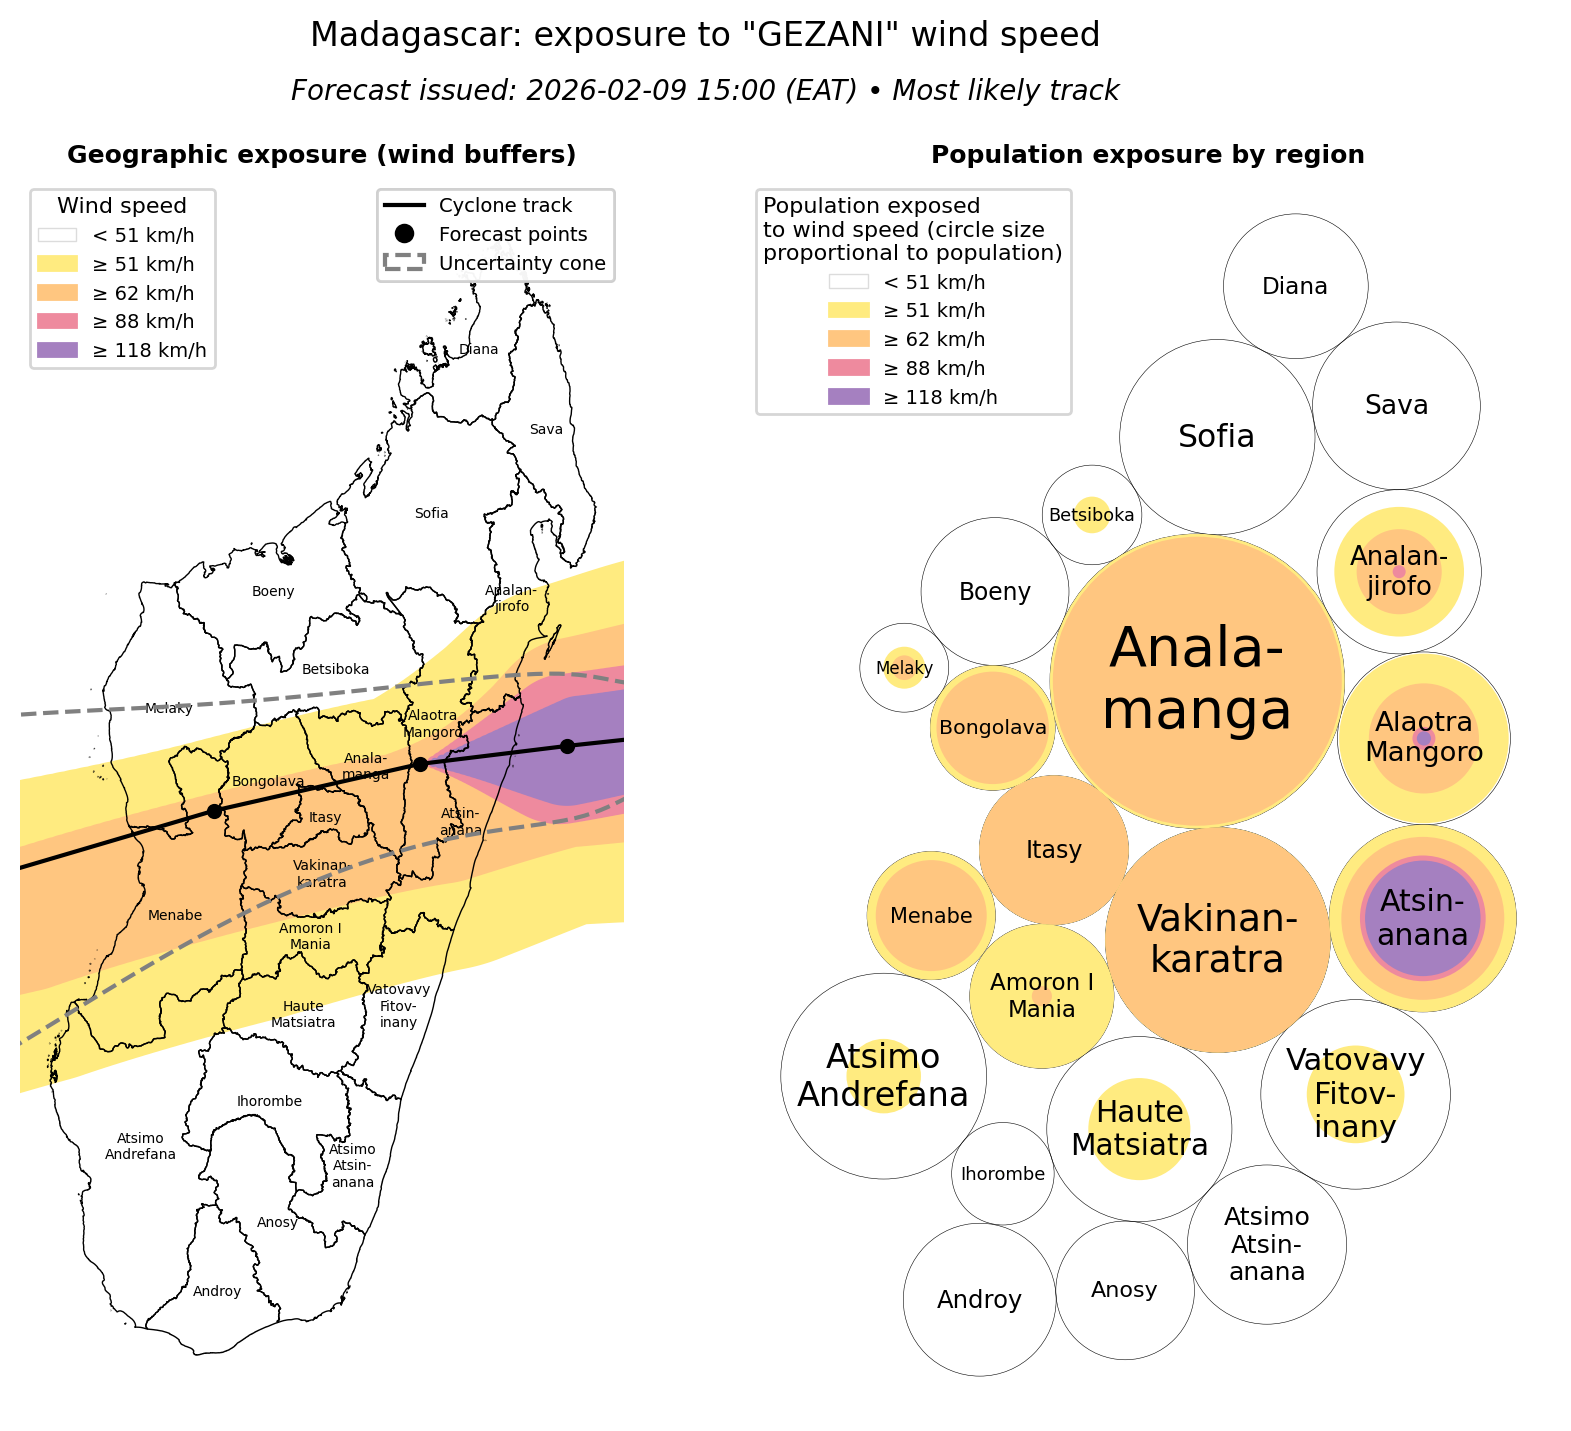

In [179]:
fig, (ax1, ax2) = plt.subplots(
    ncols=2,
    figsize=(12, 8),
    dpi=200,
)

fig_size = (9, 8)

plot_wind_buffers(
    adm1,
    gdf_buffers,
    colors=colors,
    speed_unit="km/h",
    speed_col="speed_kmh",
    ax=ax1,
    fig_size=fig_size,
    show_labels=True,
)

xs = records.geometry.x.values
ys = records.geometry.y.values

# line first (under points)
ax1.plot(
    xs,
    ys,
    color="black",
    linewidth=1.5,
    zorder=9,
)

# points on top
records.plot(
    ax=ax1,
    color="black",
    markersize=20,
    zorder=10,
)

gpd.GeoSeries([uncertainty_cone], crs=adm1.crs).plot(
    ax=ax1,
    facecolor="none",
    edgecolor="grey",
    linewidth=1.5,
    linestyle="--",
    zorder=10,
)

existing_legend = ax1.get_legend()
if existing_legend is not None:
    ax1.add_artist(existing_legend)

# --- build proxy artists for track & cone ---
track_handle = Line2D(
    [0],
    [0],
    color="black",
    linewidth=1.5,
    label="Cyclone track",
)

points_handle = Line2D(
    [0],
    [0],
    marker="o",
    linestyle="none",
    color="black",
    markersize=6,
    label="Forecast points",
)

cone_handle = Patch(
    facecolor="none",
    edgecolor="grey",
    linewidth=1.5,
    linestyle="--",
    label="Uncertainty cone",
)

# --- second legend ---
legend_track = ax1.legend(
    handles=[track_handle, points_handle, cone_handle],
    loc="upper right",
    fontsize=7,
    frameon=True,
)

ax1.add_artist(legend_track)

ax1.set_title(
    "Geographic exposure (wind buffers)",
    fontsize=9,
    fontweight="bold",
)

plot_bullseye_exposures(
    template_df,
    df_exp,
    label_col="adm_label",
    id_col="adm1_src",
    speed_col="speed_kmh",
    min_font=6,
    max_font=20,
    speeds_order=colors.keys(),
    colors=colors,
    speed_unit="km/h",
    ax=ax2,
    fig_size=fig_size,
)

ax2.set_title(
    "Population exposure by region",
    fontsize=9,
    fontweight="bold",
)

fig.suptitle(
    f'Madagascar: exposure to "{fc_details["cyclone_name"]}" wind speed',
    fontsize=12,
    y=0.98,
)

fig.text(
    0.5,
    0.93,
    f"Forecast issued: {issued_time_str} (EAT) • Most likely track",
    ha="center",
    fontsize=10,
    style="italic",
)

fig.subplots_adjust(wspace=-0.2)

speeds_kmh = sorted([int(x * 1.852) for x in speeds])

In [172]:
sorted(speeds_kmh, reverse=True)

[118, 88, 62, 51]

In [173]:
df_exp_pivot = df_exp.merge(adm1[["adm1_src", "adm1_name"]]).pivot(
    index="adm1_name", columns="speed_kmh", values="pop_exposed"
)

In [174]:
df_exp_pivot["≥ 118 km/h"] = df_exp_pivot[118]
df_exp_pivot["≥ 88 km/h"] = df_exp_pivot[88] - df_exp_pivot[118]
df_exp_pivot["≥ 62 km/h"] = df_exp_pivot[62] - df_exp_pivot[88]
df_exp_pivot["≥ 51 km/h"] = df_exp_pivot[51] - df_exp_pivot[62]

df_exp_pivot = df_exp_pivot.sort_values(51)

In [175]:
df_exp_pivot

speed_kmh,51,62,88,118,≥ 118 km/h,≥ 88 km/h,≥ 62 km/h,≥ 51 km/h
adm1_name,,,,,,,,
Boeny,0,0,0,0,0,0,0,0
Sava,0,0,0,0,0,0,0,0
Androy,0,0,0,0,0,0,0,0
Anosy,0,0,0,0,0,0,0,0
Atsimo Atsinanana,0,0,0,0,0,0,0,0
Diana,0,0,0,0,0,0,0,0
Sofia,70,0,0,0,0,0,0,70
Ihorombe,180,0,0,0,0,0,0,180
Betsiboka,71126,0,0,0,0,0,0,71126


In [176]:
colors_bar = {f"≥ {x} km/h": y for x, y in colors.items()}

In [177]:
colors_bar

{'≥ 51 km/h': 'gold',
 '≥ 62 km/h': 'darkorange',
 '≥ 88 km/h': 'crimson',
 '≥ 118 km/h': 'indigo'}

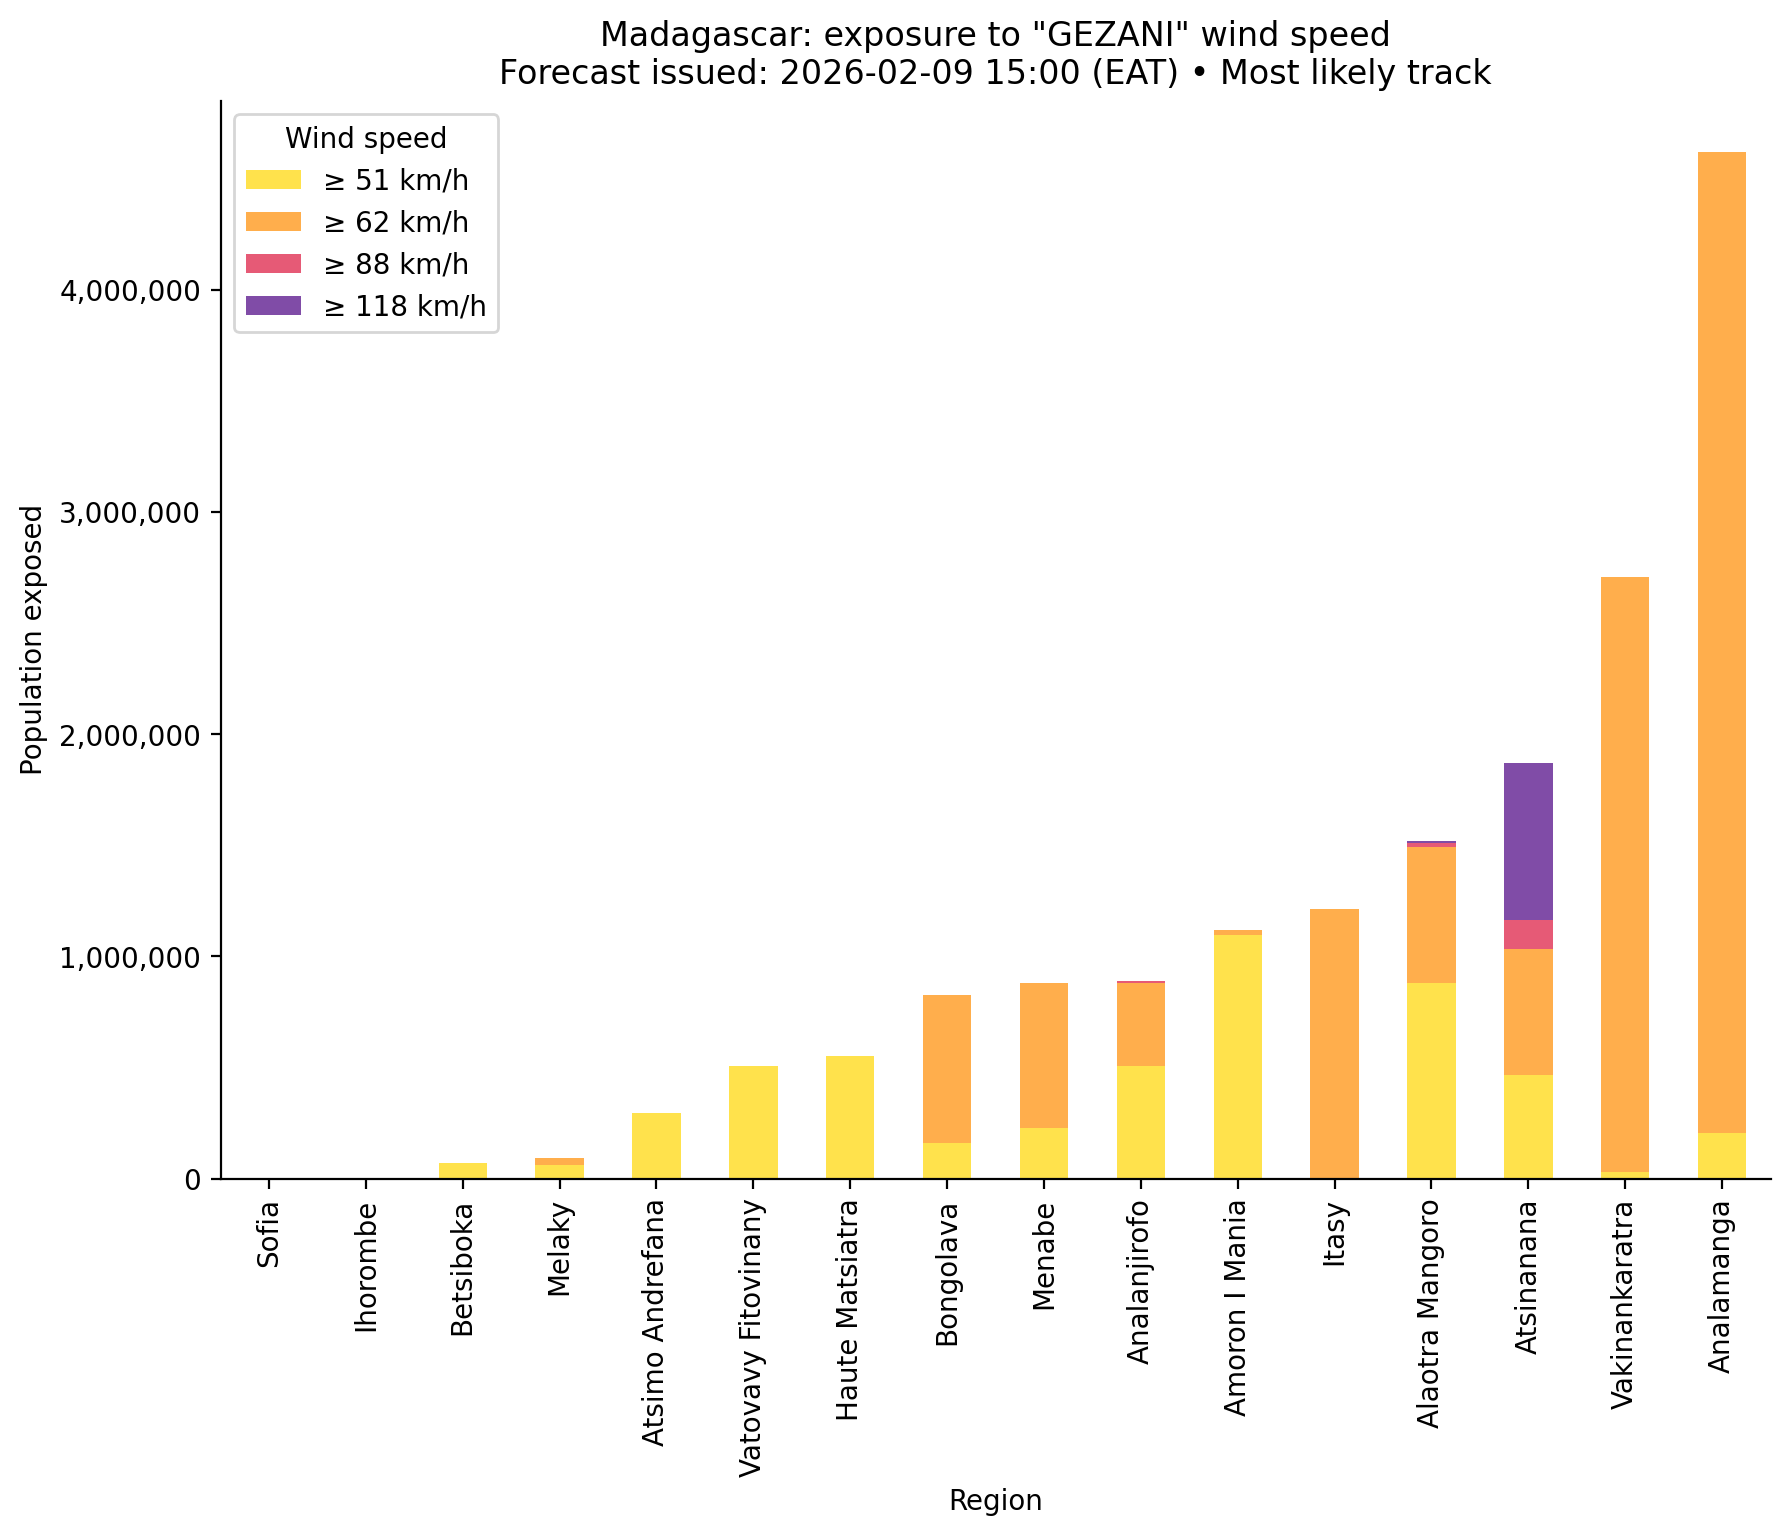

In [178]:
fig, ax = plt.subplots(dpi=200, figsize=(10, 7))

cols = [f"≥ {x} km/h" for x in speeds_kmh]

df_exp_pivot[df_exp_pivot[51] > 0][cols].plot.bar(
    ax=ax, color=colors_bar, stacked=True, alpha=0.7
)

[ax.spines[x].set_visible(False) for x in ["top", "right"]]
ax.set_xlabel("Region")
ax.set_ylabel("Population exposed")
ax.set_title(
    f'Madagascar: exposure to "{fc_details["cyclone_name"]}" wind speed\n'
    f"Forecast issued: {issued_time_str} (EAT) • Most likely track"
)

ax.legend(title="Wind speed")

ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

In [198]:
dt_utc = datetime.fromisoformat(fc_details["reference_time"])

In [208]:
issued_time_str = dt_utc.strftime("%Y%m%dT%H%MZ")

In [209]:
issued_time_str

'20260209T1200Z'

In [220]:
df_out = (
    df_exp.merge(adm1[["adm1_src", "adm1_name"]])
    .pivot(
        columns="speed_kmh",
        index=["adm1_src", "adm1_name"],
        values="pop_exposed",
    )
    .reset_index()
)
df_out.columns.name = None
df_out = df_out.sort_values("adm1_name")
df_out = df_out.rename(columns={x: f"exp_{x}_kmh" for x in [51, 62, 88, 118]})
df_out

,adm1_src,adm1_name,exp_51_kmh,exp_62_kmh,exp_88_kmh,exp_118_kmh
11,MG33,Alaotra Mangoro,1520851,641876,27944,10709
5,MG22,Amoron I Mania,1117980,21547,0,0
0,MG11,Analamanga,4621438,4418074,0,0
10,MG32,Analanjirofo,889696,383251,8957,0
17,MG52,Androy,0,0,0,0
18,MG53,Anosy,0,0,0,0
16,MG51,Atsimo Andrefana,293591,0,0,0
8,MG25,Atsimo Atsinanana,0,0,0,0
9,MG31,Atsinanana,1868822,1404818,836194,706177
14,MG43,Betsiboka,71126,0,0,0


In [221]:
out_path = f'temp/{fc_details["cyclone_name"].lower()}_issued_{issued_time_str}_mdg_adm1_exposure.csv'

In [222]:
df_out.to_csv(out_path, index=False)